# Lithology Classification Using Machine Learning

Miloš Božić, NIS-GAZPROM

This notebook demonstrates how to train a machine learning algorithm to predict lithology from well log data.

The dataset we will use is log data from __25__ wells that have been labeled with a lithology type based on oberservation of core.

This workshop was inspired by the publication [Facies classification using machine learning](https://library.seg.org/doi/abs/10.1190/tle35100906.1)  in The Leading Edge and [SEG Geophysical Tutorial Machine Learning Contest 2016](https://github.com/seg/2016-ml-contest).

## Data set exploration and cleaning

First, we will examine the data set we will use to train the classifier. The training data is contained in the file `Data_DigitalCore.csv`. The dataset consists of 4 wireline log measurements, two indicator variables and a two lithology labels, primary and secondary. In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type). We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

pd.set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [2]:
filename = 'Data_DigitalCore.csv'
data = pd.read_csv(filename)
data

,WellName,MD,CN,GR,ZDEN,RT,Lithology Primary,Lithology Secondary
0,Well-57,1272.600,0.21,37.21,2.42,2.44,108,103.0
1,Well-57,1272.700,0.20,36.86,2.42,2.53,108,103.0
2,Well-57,1272.800,0.19,36.30,2.42,2.70,108,103.0
3,Well-57,1272.900,0.18,35.38,2.42,2.96,108,103.0
4,Well-57,1273.000,0.17,34.25,2.43,3.33,108,103.0
...,...,...,...,...,...,...,...,...
15827,Well-21,2187.388,0.08,82.71,2.67,40.18,201,114.0
15828,Well-21,2187.488,0.08,81.49,2.68,40.33,201,114.0
15829,Well-21,2187.588,0.07,81.30,2.68,39.59,201,114.0
15830,Well-21,2187.688,0.07,82.33,2.68,38.04,201,114.0


This dataset is from 25 wells (with 15832 examples), consisting of a set of four predictor variables and a primary and secondary rock facies (class) for each example vector. Facies are based on examination of cores from 25 wells taken vertically at some vertical sample rate intervals.

The predictor features are:

* [Gamma ray (GR)](http://petrowiki.org/Gamma_ray_logs)
* [Resistivity (RT)](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging)
* [Neutron porosity (CN)](https://petrowiki.org/Neutron_porosity_logs)
* [Density (ZDEN)](https://en.wikipedia.org/wiki/Density_logging)

We have 20 facies (classes of rocks):

Code Value|Lithology Name|Rock Type
:--------:|:------------:|:--------:
101 | Sandstone | `Sedimentary`
102	| Siltstone | `Sedimentary`
103	| Marl | `Sedimentary`
104	| Clay | `Sedimentary`
105	| Mudstone| `Sedimentary`
107	| Coal | `Sedimentary`
108	| Calcite | `Sedimentary`
109	| Dolomite | `Sedimentary`
113	| Conglomerate | `Sedimentary`
114	| Breccia | `Sedimentary`
201	| Crystalline schist | `Metamorphic`
202	| Gneiss | `Metamorphic`
205	| Amfibolite | `Metamorphic`
210	| Metamorphic rock | `Metamorphic`
304	|Granite | `Plutonic/Volcanic`
305	| Granodiorite | `Plutonic/Volcanic`
306	| Tuffite | `Plutonic/Volcanic`
308	| Vulcanic rock | `Plutonic/Volcanic`
309	| Granitoid | `Plutonic/Volcanic`
310	| Diorite | `Plutonic/Volcanic`

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur. The following table shows some examples:

Lithology Primary|Lithology Secondary|Full Lithology
:--------:|:------------:|:--------:
101 | 103 | Marly Sandstone
101	| 0 | Sandstone
108	| 109 | Dolomitic Limestone
104	| 107 | Coaly Shale
113	| 114 | Breccied Conglomerate
114	| 0 | Breccia

Let's clean up this dataset and check is everthing prepared for modeling.
For example, check the total number of wells and classes, their types, ...

Get all columns:

In [3]:
list(data)

['WellName',
 'MD',
 'CN',
 'GR',
 'ZDEN',
 'RT',
 'Lithology Primary',
 'Lithology Secondary']

Get columns types:

In [4]:
data.dtypes

WellName                object
MD                     float64
CN                     float64
GR                     float64
ZDEN                   float64
RT                     float64
Lithology Primary        int64
Lithology Secondary    float64
dtype: object

Get total number of wells:

In [5]:
len(data['WellName'].unique())

25

Get total number of classes:

In [6]:
data['Lithology Primary'].unique()

array([108, 101, 102, 103, 114, 104, 113, 309, 305, 201, 306, 308, 202,
       109, 310, 210, 304, 205])

In [7]:
data['Lithology Secondary'].unique()

array([ 103.  ,  104.  ,  108.  ,  102.  ,    0.  ,  101.  ,  113.  ,
        114.  ,  109.  ,  305.  ,  309.  , -999.25,  306.  ,  107.  ,
        201.  ,  105.  ])

Make union of Primary and Secondary classes:

In [8]:
np.union1d(data['Lithology Primary'].unique(), data['Lithology Secondary'].unique())

array([-999.25,    0.  ,  101.  ,  102.  ,  103.  ,  104.  ,  105.  ,
        107.  ,  108.  ,  109.  ,  113.  ,  114.  ,  201.  ,  202.  ,
        205.  ,  210.  ,  304.  ,  305.  ,  306.  ,  308.  ,  309.  ,
        310.  ])

Convert WellName columns and classes columns to categry type

In [9]:
data['WellName'] = data['WellName'].astype('category')
data['Lithology Primary'] = data['Lithology Primary'].astype('category')
data['Lithology Secondary'] = data['Lithology Secondary'].astype('int')
data['Lithology Secondary'] = data['Lithology Secondary'].astype('category')
data

,WellName,MD,CN,GR,ZDEN,RT,Lithology Primary,Lithology Secondary
0,Well-57,1272.600,0.21,37.21,2.42,2.44,108,103
1,Well-57,1272.700,0.20,36.86,2.42,2.53,108,103
2,Well-57,1272.800,0.19,36.30,2.42,2.70,108,103
3,Well-57,1272.900,0.18,35.38,2.42,2.96,108,103
4,Well-57,1273.000,0.17,34.25,2.43,3.33,108,103
...,...,...,...,...,...,...,...,...
15827,Well-21,2187.388,0.08,82.71,2.67,40.18,201,114
15828,Well-21,2187.488,0.08,81.49,2.68,40.33,201,114
15829,Well-21,2187.588,0.07,81.30,2.68,39.59,201,114
15830,Well-21,2187.688,0.07,82.33,2.68,38.04,201,114


In [10]:
data.dtypes

WellName               category
MD                      float64
CN                      float64
GR                      float64
ZDEN                    float64
RT                      float64
Lithology Primary      category
Lithology Secondary    category
dtype: object

Find how many rows in Lithology Seconday column has unexpected value -999.25

In [11]:
data[data['Lithology Secondary'] == -999.25]

,WellName,MD,CN,GR,ZDEN,RT,Lithology Primary,Lithology Secondary


Before we converted Lithology Secondary column to category type, we conveted it to int type and -999.25 value become -999

In [12]:
data['Lithology Secondary'].unique()

[103, 104, 108, 102, 0, ..., -999, 306, 107, 201, 105]
Length: 16
Categories (16, int64): [103, 104, 108, 102, ..., 306, 107, 201, 105]

In [13]:
data[data['Lithology Secondary'] == -999]

,WellName,MD,CN,GR,ZDEN,RT,Lithology Primary,Lithology Secondary
2170,Well-32,2315.449,-999.25,78.4,-999.25,1.11,104,-999


There is only one row with this bed class, let's drop this row

In [14]:
data.drop(data[data['Lithology Secondary'] == -999].index, inplace=True)
len(data[data['Lithology Secondary'] == -999])

0

In [15]:
data.describe()

,MD,CN,GR,ZDEN,RT
count,15831.000000,15831.000000,15831.000000,15831.000000,15831.000000
mean,1894.067014,-33.552062,64.611327,-18.781558,-3.393196
std,595.569586,180.610528,147.962652,144.384813,174.847956
min,613.000000,-999.250000,-999.250000,-999.250000,-999.250000
25%,1394.000000,0.140000,66.240000,2.360000,4.240000
50%,2179.500000,0.190000,85.080000,2.500000,7.980000
75%,2484.550000,0.290000,99.160000,2.590000,16.425000
max,2589.300000,1.080000,255.690000,3.010000,7928.270000


Min value for each predictor columns is -999.25, this is value which we have to treat as Nan value and we will drop these rows. 

In [16]:
data.isna().sum()

WellName               0
MD                     0
CN                     0
GR                     0
ZDEN                   0
RT                     0
Lithology Primary      0
Lithology Secondary    0
dtype: int64

In [17]:
data.loc[(data.CN == -999.25) | (data.GR == -999.25) | (data.ZDEN == -999.25) | (data.RT == -999.25)] = np.nan

In [18]:
data.isna().sum()

WellName               797
MD                     797
CN                     797
GR                     797
ZDEN                   797
RT                     797
Lithology Primary      797
Lithology Secondary    797
dtype: int64

Let's drop all rows with Nan values

In [19]:
data.dropna(inplace=True)
data.isna().sum()

WellName               0
MD                     0
CN                     0
GR                     0
ZDEN                   0
RT                     0
Lithology Primary      0
Lithology Secondary    0
dtype: int64

In [20]:
data.describe()

,MD,CN,GR,ZDEN,RT
count,15034.000000,15034.000000,15034.000000,15034.000000,15034.000000
mean,1903.607863,0.224034,85.118620,2.475606,17.167733
std,592.657487,0.110086,28.935469,0.177640,72.975977
min,615.100000,-0.010000,9.990000,1.640000,1.010000
25%,1396.125000,0.140000,68.492500,2.370000,4.410000
50%,2192.750000,0.200000,85.865000,2.510000,8.305000
75%,2493.827500,0.290000,99.990000,2.590000,16.497500
max,2589.300000,0.820000,255.690000,2.980000,7928.270000


Here we will save our cleared dataframe to csv file and load the same file back. We do this because sometimes notebook starts to behave unpredictable and we get strange results. This little trick would save us from some trouble later.

In [23]:
data.to_csv('Data_cleared.csv', index=False)
data = pd.read_csv('Data_cleared.csv')

## Plot well data

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots.

In [24]:
# 101=Sandstone 102=Siltstone 103=Marl 104=Clay 105=Mudstone 107=Coal 108=Calcite 109=Dolomite 113=Conglomerate 114=Breccia 
# 201=Crystalline schist 202=Gneiss 205=Amfibolite 210=Metamorphic rock 
# 304=Granite 305=Granodiorite 306=Tuffite 309=Granitoid 310=Diorite

facies_colors = ['#66FF63', '#A442FF', '#FF9454', '#5047FF', '#8FE85A', '#0BB345', '#E8704D', '#4166E8', '#D7FF70',
                 '#FF6E62', '#29FF74', '#55A8FF', '#E8E55A', '#E84D6E', '#41BEE8', '#FFEC63', '#FF54CE', '#B37414',
                 '#47FFFD', '#FFFFFF']

#facies_labels = [str(i) for i in np.union1d(data['Lithology Primary'].unique(), data['Lithology Secondary'].unique())]
facies_labels = [i for i in data['Lithology Primary'].unique()]
facies_colors = facies_colors[:len(facies_labels)]

# facies_color_map is a dictionary that maps facies labels
# to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

# Replace the Facies number with their label
#facies_number_to_label = {i: label for i, label in enumerate(facies_labels, 1)}
#data['FaciesLabels'] = data['Lithology Primary'].replace(facies_number_to_label)
#data['FaciesLabels'] = pd.Categorical(data['FaciesLabels'], ordered=True, categories=facies_labels)

 Let's plot a histogram of the number of training examples for each facies class.

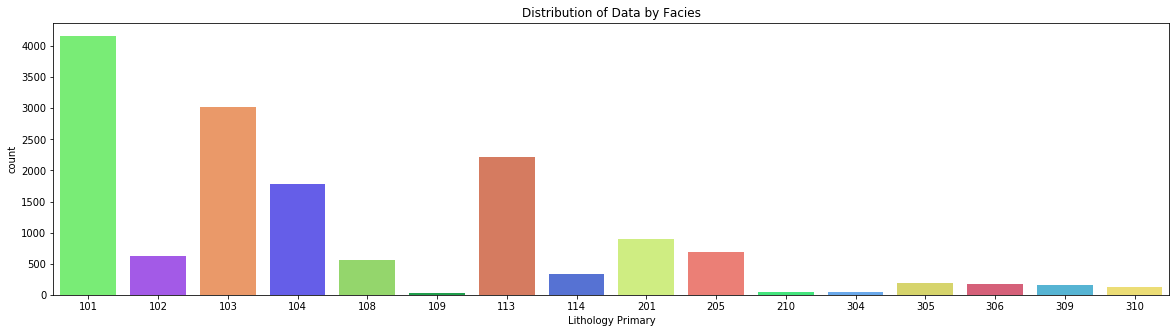

In [25]:
plt.figure(figsize=(20,5))
ax = sns.countplot(data=data, x='Lithology Primary', palette=facies_colors)
ax.set_title('Distribution of Data by Facies');

Let's visualize how two properties vary with rock type. For this we will use crossplots in [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/). Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies. The same colormap form above is used to represent the all our facies.

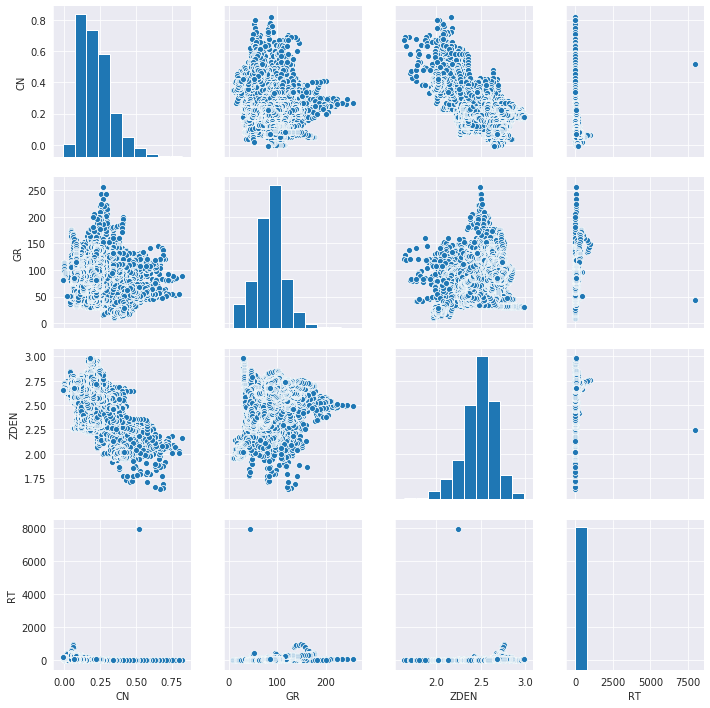

In [26]:
with sns.axes_style('darkgrid'):
    sns.pairplot(data.drop(['WellName','MD', 'Lithology Primary', 'Lithology Secondary'], axis=1))

One poit looks like outlier, let's go back to check data.descriptio() output and try to find and filter this point.

In [27]:
data[data.RT>1000]

,WellName,MD,CN,GR,ZDEN,RT,Lithology Primary,Lithology Secondary
10094,Well-80,830.7,0.52,43.97,2.24,7928.27,103,0


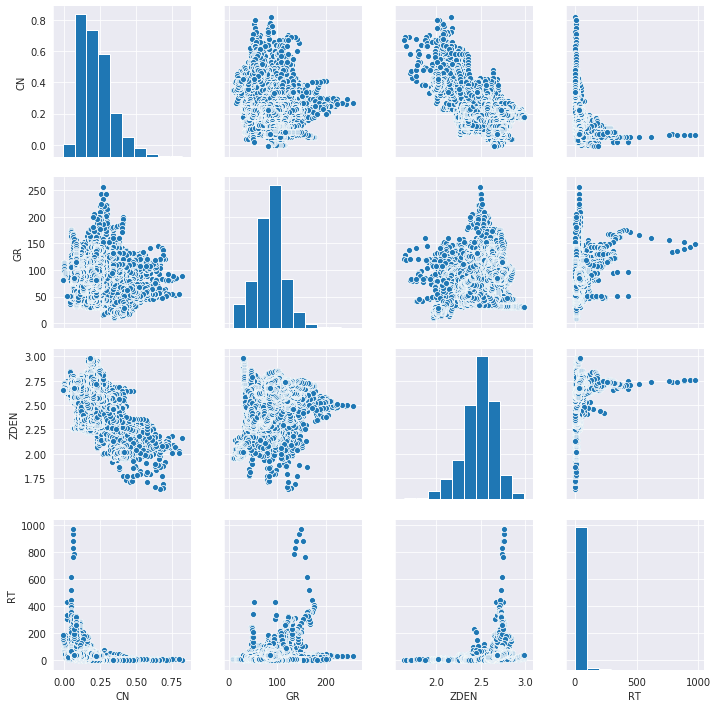

In [28]:
data.drop(data[data.RT > 1000].index, inplace=True)
with sns.axes_style('darkgrid'):
    sns.pairplot(data.drop(['WellName','MD', 'Lithology Primary', 'Lithology Secondary'], axis=1))

In [29]:
data

,WellName,MD,CN,GR,ZDEN,RT,Lithology Primary,Lithology Secondary
0,Well-57,1272.600,0.21,37.21,2.42,2.44,108,103
1,Well-57,1272.700,0.20,36.86,2.42,2.53,108,103
2,Well-57,1272.800,0.19,36.30,2.42,2.70,108,103
3,Well-57,1272.900,0.18,35.38,2.42,2.96,108,103
4,Well-57,1273.000,0.17,34.25,2.43,3.33,108,103
...,...,...,...,...,...,...,...,...
15029,Well-21,2187.388,0.08,82.71,2.67,40.18,201,114
15030,Well-21,2187.488,0.08,81.49,2.68,40.33,201,114
15031,Well-21,2187.588,0.07,81.30,2.68,39.59,201,114
15032,Well-21,2187.688,0.07,82.33,2.68,38.04,201,114


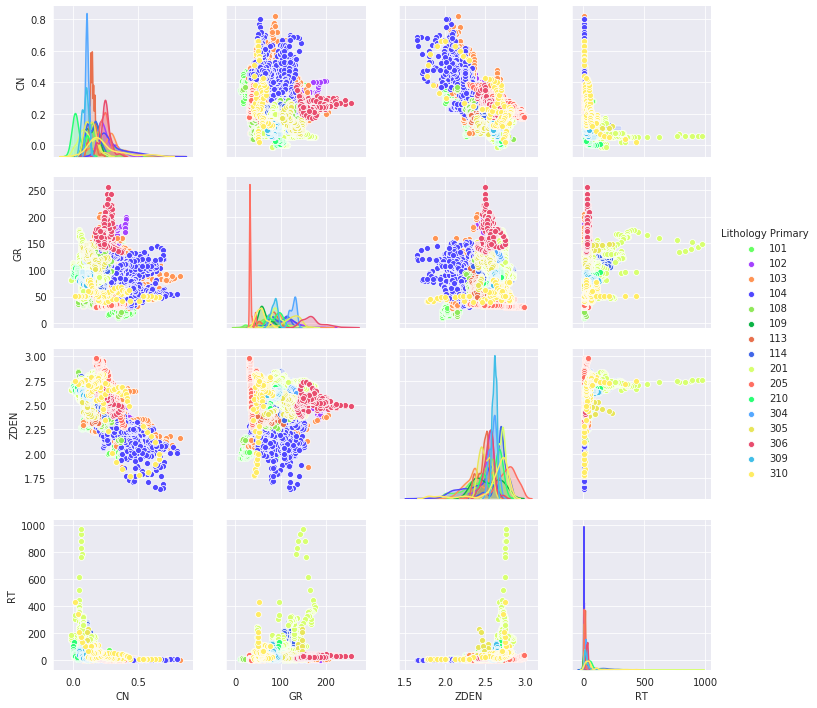

In [30]:
with sns.axes_style('darkgrid'):
    sns.pairplot(data, vars=['CN', 'GR', 'ZDEN', 'RT'],
                 hue='Lithology Primary', palette=facies_colors,
                 plot_kws={'linewidths': 0.3})

Method for individual wells data visualisation in a more familiar log plot form. We will create plots based on four well log variables, as well as a log for facies labels. The plots are based on the those described in Alessandro Amato del Monte's [tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [31]:
def make_facies_log_plot(logs, feature_names, facies_labels, facies_colors,
                         facies_name='Lithology Primary', predicted_facies_name=None,
                         depth_name='MD'):
    
    """Create log plots of features, true facies, and optionally, predicted facies.

    These columns must be in the dataframe:
        CN, GR, ZDEN, RT

    Parameters
    ----------
    logs: DataFrame
    feature_names: array-like
        Sequence of column names.
    facies_labels: array-like
        Sequence of names mapping to each facies
    facies_colors: array-like
        matplotlib-compatible sequence of colors
    facies_name: string (optional)
        Name of the column containing the real facies.
    predicted_facies_name: string (optional)
        Name of the column containing the predicted facies.
    depth_name: string (optional)
        Name of the column containing the depth data. "MD" by default.

    """
    # make sure logs are sorted by depth
    logs = logs.sort_values(by=depth_name)
    
    # Prepare colors
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
    color_cycle = plt.cycler('color', ['C{}'.format(i) for i in range(20)])

    # Vertical extent
    ztop = logs[depth_name].min()
    zbot = logs[depth_name].max()

    # Name to use for X labels
    facies_col_names = [facies_name]
    if predicted_facies_name is not None:
        facies_col_names.append(predicted_facies_name)

    ncols_facies = len(facies_col_names)
    ncols_features = len(feature_names)

    ncols = ncols_features + ncols_facies
    f, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(9, 16))
    # Plot features
    for ax, name, color in zip(axes, feature_names, color_cycle):
        ax.plot(logs[name], logs[depth_name], **color)

    # Plot facies
    for ax, name in zip(axes[ncols_features:], facies_col_names):
        im_data = logs.loc[:, name:name]
        im = ax.imshow(im_data, interpolation='none', aspect='auto',
                       cmap=cmap_facies,
                       extent=(-1, 1, zbot, ztop))

    # Add colorbar to the last axis, which contains facies
    divider = make_axes_locatable(axes[-1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label((10*' ').join('{:^4}'.format(label) for label in facies_labels))
    cbar.set_ticks(range(0, len(facies_labels)))
    cbar.set_ticklabels('')

    for ax, name in zip(axes, feature_names):
        ax.set_ylim(ztop, zbot)
        ax.invert_yaxis()
        ax.grid()
        ax.locator_params(axis='x', nbins=3)
        ax.set_xlabel(name)
        ax.set_xlim(logs[name].min(), logs[name].max())

    for ax, name in zip(axes[ncols_features:], facies_col_names):
        ax.set_xlabel(name)
        ax.set_xticks([])

    for ax in axes[1:]:
        ax.set_yticklabels([])

    f.suptitle('Well: %s' % logs.iloc[0]['WellName'], fontsize=14, y=0.90)

Let's show log plot for one random well or some specific well. 

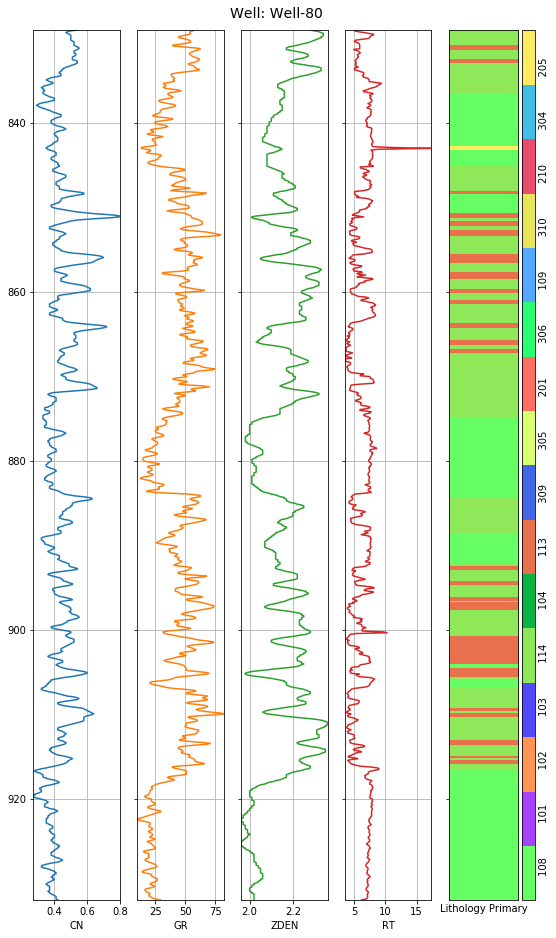

In [32]:
import random

wells = data['WellName'].unique()
idx = random.randint(0, len(wells)-1)

#well = wells[idx]
well = 'Well-80'
    
make_facies_log_plot(
    data[data['WellName'] == well],
    ['CN', 'GR', 'ZDEN', 'RT'],
    facies_labels,
    facies_colors
)


## Modeling

First we will split our dataset to train and test set, which we will use for models training and testing. 

In [36]:
from sklearn.model_selection import train_test_split

X = data[['CN', 'GR', 'ZDEN', 'RT']]
y = data['Lithology Primary']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 0)

Let's create an initial classification model for example with [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Because we have multiple and imbalanced classes, for our model evaluation we will use F1 score.

In [38]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', penalty='l2')
lr.fit(Xtrain, Ytrain)

/home/milos/anaconda3/envs/workshop/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Run trained model on test set and calculate F1 score.

In [40]:
from sklearn.metrics import recall_score

y = lr.predict(Xtrain)
f1_score(Ytrain, y, average='micro')

0.4878596374521869

Do we get optimal model?
Of course not, we train logistic regression with only one set of hyper parameters and we are not sure are we use optimal hyper parameters values.

Let's try some other hyper parameters, for that we will use GridSearchCV with F1 scoring argument.

In [71]:
import warnings
warnings.filterwarnings('ignore')

pipe = Pipeline([
    ('clf', LogisticRegression())
])

params = {
    'clf__penalty': ['l2'],
    'clf__C': [1e-03, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'clf__solver': ['lbfgs', 'saga'],
    'clf__multi_class': ['ovr'],
}

search = GridSearchCV(pipe, params, cv=5, scoring='f1_micro')

search.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                 

Let's try [Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) method with some hyper parameters search using again grid-search.

In [75]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('rfc', RandomForestClassifier())
])

params = {
    'rfc__n_estimators': [2, 10, 100, 200],
    'rfc__max_depth': [None, 2, 4]
}

search = GridSearchCV(pipe, params, cv=5, scoring='f1_micro')

search.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                      

Get the best score and best estimator.

In [76]:
search.best_score_, search.best_estimator_

(0.869615832363213, Pipeline(memory=None,
          steps=[('rfc',
                  RandomForestClassifier(bootstrap=True, class_weight=None,
                                         criterion='gini', max_depth=None,
                                         max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=200, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False))],
          verbose=False))

The score we get by computing the f1_score as a standalone function is slighly different because it's the score for the entire training set, not the one obtained via cross-validation:

In [77]:
from sklearn.metrics import recall_score

y = search.predict(Xtrain)
f1_score(Ytrain, y, average='micro')

1.0

We can also look at the error in more details using a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). It is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The rows of the confusion matrix correspond to the actual facies labels. The columns correspond to the labels assigned by the classifier. The entries along the diagonal are the facies that have been correctly classified and all the labels off the diagonal were misclassified.

Confusion matrix plot function below is code adapted from [plot_confusion_matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [78]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True facies',
           xlabel='Predicted facies')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.set_size_inches(14, 10)
    fig.tight_layout()
    return ax

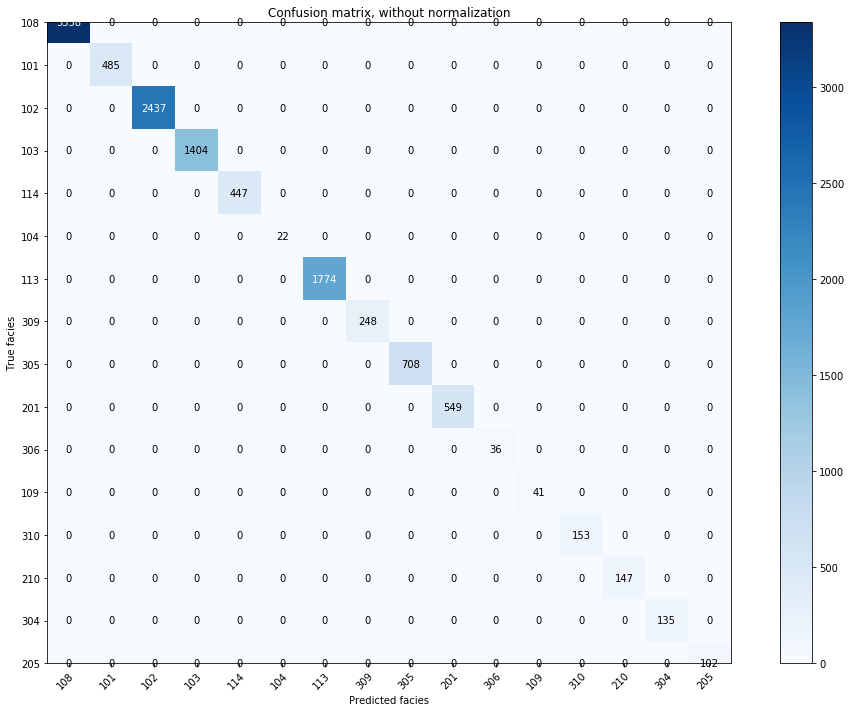

In [79]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(Ytrain, y)
#display_cm(conf, facies_labels, hide_zeros=True)
plot_confusion_matrix(Ytrain, y, classes=facies_labels)

### Save model

When we found the best model, let's save it for later use in production. For that we will use [picke](https://docs.python.org/3/library/pickle.html), Python's object serialization library.

In [119]:
import pickle
import bz2

filename = 'final_model.pkl'
pickle.dump(search, open(filename, 'wb'))


When we save our model, file size will be greater then 100Mb, but we can compress it to get smaller file, in that case file size is 5Mb.

In [121]:
filename = 'final_model'
sfile = bz2.BZ2File(filename, 'w')
pickle.dump(search, sfile)

Try to load saved model and do some prediction.

In [122]:
with bz2.open(filename, 'r') as fp:
    loaded_model = pickle.load(fp)
    
y = search.predict(Xtrain)
f1_score(Ytrain, y, average='micro')

1.0

## Model deployment

### Deployment using Flask web app

We will use [Flaks](http://flask.palletsprojects.com/en/1.1.x/) micro web framework to make our deployment app.
Flask aims to keep the core simple but extensible and yours app can be only in one file or if you need, you can build very big app. Flask doesn't push you to use any specific database or template engine, you would decide which one you whant to use. And it is easy because Flask supports extensions to add many functionality to your application.

Our app would return model predictions through form submiting or web querying, and all code is only in one file _app.py_ plus HTML _view.html_ file for form view.
In _app.py_ file we have two main methods for coresponding routh path. Form submiting is implemented with _index()_ method which would render form in view.html page through GET request and in POST request would submit inputs back. Method then use these input values to do prediction and return result.
Second method _predict()_ implement only POST request and it gets json object through which you will send inputs. It parses json object, extract inputs and do model prediction, pack results in json and send it as response.

All app code is here [app code repo](https://github.com/milosbozic/DSC5-workshop-flask-app).

#### **app.py**

```
import pandas as pd
from flask import Flask, jsonify, request, render_template, url_for
import pickle
import bz2
import json
import requests

# load model
#model = pickle.load(open('final_model.pkl','rb'))
with bz2.open('final_model', 'r') as fp:
    model = pickle.load(fp)

# app
app = Flask(__name__)

# routes
@app.route('/', methods=['GET', 'POST'])
def index():

    result = None
    if request.method == 'POST':
        cn = request.form.get('cn')
        gr = request.form.get('gr')
        zden = request.form.get('zden')
        rt = request.form.get('rt')

        data = {"CN": cn, "GR": gr, "ZDEN": zden, "RT": rt}
        data.update((x, [y]) for x, y in data.items())
        result = model.predict(pd.DataFrame.from_dict(data))
    
    return render_template('view.html', result=result)

@app.route('/api', methods=['POST'])
def predict():
    # get data
    data = request.get_json(force=True)
    #print(data)
    
    # convert data into dataframe
    data.update((x, [y]) for x, y in data.items())
    data_df = pd.DataFrame.from_dict(data)

    # predictions
    result = model.predict(data_df)

    # send back to browser
    output = {'results': int(result[0])}

    # return data
    return jsonify(results=output)

if __name__ == '__main__':
    app.run(port = 5000, debug=True)
```

#### **view.html**  
_main part of code only shown here_

```
<!doctype html>
<html lang="en">
  <head>
    
    <!-- Bootstrap CSS -->
    
    . . . . . . .

    <title>DSC5 workshop</title>
  </head>
  <body>
    <div class="container">
        <h2 class="mb-4">DSC5 workshop model deployment example</h2>
        {% if result %}
            <p class="text-danger font-weight-bold">{{result}}</p>
        {% endif %}

        <form action="" method="POST">
            <div class="row">
                <div class="form-group">
                    <label for="cn">CN</label>
                    <input type="number" step=any class="form-control" id="cn" name='cn' placeholder="Enter CN value">
                </div>
                <div class="form-group">
                    <label for="gr">GR</label>
                    <input type="number" step=any class="form-control" id="gr" name='gr' placeholder="Enter GR value">
                </div>
                <div class="form-group">
                    <label for="zden">ZDEN</label>
                    <input type="number" step=any class="form-control" id="zden" name='zden' placeholder="Enter ZDEN value">
                </div>
                <div class="form-group">
                    <label for="rt">RT</label>
                    <input type="number" step=any class="form-control" id="rt" name='rt' placeholder="Enter RT value">
                </div>
            </div>
            <button type="submit" class="btn btn-primary">Submit</button>
        </form>

    </div>

    <!-- Optional JavaScript -->
    <!-- jQuery first, then Popper.js, then Bootstrap JS -->
    
    . . . . . .
        
</html>
```

Let's test our deploy app. We will make one example from our test set and send it to server throught post request.  
We will run our app localy using Flask's integrated development server but also we will deploy our app on [Heroku](https://www.heroku.com) PaaS cloud service.  
How to run Flask app localy you can find here [Flask quickstart](https://flask.palletsprojects.com/en/1.1.x/quickstart/).  
How to deploy Flaks app to Heroku you can find here [Deploy Flask app to Heroku](https://towardsdatascience.com/create-an-api-to-deploy-machine-learning-models-using-flask-and-heroku-67a011800c50).

In [137]:
import requests, json

# Url to our server deployment app
url = 'http://127.0.0.1:5000/api' #If local testing
#url = 'https://dsc5workshopflaskapp.herokuapp.com/api'

# Make sample for test, take one random example from test set

idx = random.randint(0, len(Xtest))
xtest = Xtest.iloc[idx]
ytest = Ytest.iloc[idx]

print(xtest, ytest)

# Conver pands Series to dict object
data = xtest.to_dict()

# Make json in format like this {"CN": 0.11, "GR": 60.31, "ZDEN": 2.59, "RT": 8.88}
data = json.dumps(data)

# Send post request
send_request = requests.post(url, data)
print(send_request)

# Get results from server app
print(send_request.json())



CN       0.16
GR      80.44
ZDEN     2.69
RT      47.18
Name: 14538, dtype: float64 114
<Response [200]>
{'results': {'results': 114}}
